In [1]:
import numpy as np
import pandas as pd
from skimage import measure
import os
import matplotlib.pyplot as plt
import multiprocessing
cpu_count = multiprocessing.cpu_count()
from multiprocessing import Pool

from matplotlib.patches import Rectangle
import matplotlib.patches as patches

## Read data

In [2]:
directory = "./data"
dfs =[]
for filename in sorted(os.listdir(directory)):
    if (filename.startswith("data_") and filename.endswith(".pkl")): 
        print (filename)
        dfs.append(pd.read_pickle(os.path.join(directory, filename)))
    else:
        continue
        
df = pd.concat(dfs)
df = df.sort_index()
print (len(df))

data_p01.pkl
data_p02.pkl
data_p03.pkl
data_p04.pkl
data_p05.pkl
data_p06.pkl
data_p07.pkl
data_p08.pkl
data_p09.pkl
data_p10.pkl
data_p11.pkl
data_p12.pkl
data_p13.pkl
data_p14.pkl
data_p15.pkl
data_p16.pkl
data_p17.pkl
data_p18.pkl
data_p19.pkl
data_p20.pkl
data_p21.pkl
data_p22.pkl
data_p23.pkl
data_p24.pkl
data_p25.pkl
data_p26.pkl
data_p27.pkl
data_p28.pkl
data_p29.pkl
data_p30.pkl
data_p31.pkl
data_p32.pkl
data_p33.pkl
241120


In [3]:
df.head()

,Participant,Condition,Matrix,Pitch,Yaw,TimeOffset
0,1,2,"[[0, 0, -1, 1, 0, 0, -3, 0, -2, -2, -1, -3, -1...",38.856377,-2.493793,0.993750
1,1,2,"[[0, 0, -1, 1, 0, 0, -3, 0, -2, -2, -1, -3, -1...",38.597713,-2.538246,0.999065
2,1,2,"[[0, 0, -1, 1, 0, 0, -3, 0, -2, -2, -1, -3, -1...",37.787099,-3.215579,-0.005882
3,1,2,"[[0, 0, -1, 1, 0, 0, -3, 0, -2, -2, -1, -3, -1...",38.310998,-3.407330,-0.001333
4,1,2,"[[0, 0, -1, 1, 0, 0, -3, 0, -2, -2, -1, -3, -1...",38.392563,-3.486370,-0.001205


## Flip data in yaw

In [4]:
df["IsFlipped"] = False

In [5]:
%%time

def doJob (df):
    lst = []
    for i, d in df.iterrows():
        lst.append(np.fliplr(d.Matrix))
    return lst

p = Pool(cpu_count)


data = np.array_split(df, cpu_count)
pool_results = p.map(doJob, data)
p.close()
del data

results = []
for result in pool_results:
    results.extend(result)

CPU times: user 2.26 s, sys: 1.39 s, total: 3.65 s
Wall time: 3.45 s


In [6]:
df2 = df.copy(deep=True)
df2.Matrix = results
df2.Yaw = df2.Yaw *-1
df2.IsFlipped = True

df = pd.concat([df,df2])
df = df.sort_index()
df = df.reset_index()
df = df.rename(columns={"index":"Pair"})
df.head()

,Pair,Participant,Condition,Matrix,Pitch,Yaw,TimeOffset,IsFlipped
0,0,1,2,"[[0, 0, -1, 1, 0, 0, -3, 0, -2, -2, -1, -3, -1...",38.856377,-2.493793,0.993750,False
1,0,1,2,"[[-1, -2, -1, -3, -1, -2, -2, 0, -3, 0, 0, 1, ...",38.856377,2.493793,0.993750,True
2,1,1,2,"[[0, 0, -1, 1, 0, 0, -3, 0, -2, -2, -1, -3, -1...",38.597713,-2.538246,0.999065,False
3,1,1,2,"[[-1, -2, -1, -3, -1, -2, -2, 0, -3, 0, 0, 1, ...",38.597713,2.538246,0.999065,True
4,2,1,2,"[[0, 0, -1, 1, 0, 0, -3, 0, -2, -2, -1, -3, -1...",37.787099,-3.215579,-0.005882,False


## Blob detection

In [7]:
def loadImg(img):
    im = np.copy(img)
    
    # The Nexus5 capacitive sensor is extreamly noizy in the upper rows 
    # Since no one touched there we can remove the noise to be able
    # to perfercly detect the finger
    im[:7] = 0
    
    # Reduction of noise as already described by Xiao et al.
    im[im < 4] = 0
    
    # Filter sensore overshoots
    im[im > 255] = 255
    
    im = im.astype(np.float64)
    return im

In [8]:
def findCon (img):
    contours = measure.find_contours(img, 35)
    points_to_approx = []
    highest_val = 0
    for n, contour in enumerate(contours):
        if (len(contour) > highest_val and len(contour) > 0):
            points_to_approx = contour
            highest_val = len(contour)

    if len(points_to_approx) > 5:
        return points_to_approx[:, 1], points_to_approx[:, 0]
    else:
        return None, None

In [9]:
def doJob (df):
    lst = []
    for i, d in df.iterrows():
        img = loadImg(d.Matrix)
        x,y = findCon(img)
        if (not(x is None)):
            x1,y1,x2,y2 = int(x.min()-1), int(y.min()-1), int(x.max()+2), int(y.max()+2)
            if x1 < 0:
                x1 = 0
            if y1 < 0:
                y1 = 0
            if x2 > 15:
                x2 = 15
            if y2 > 27:
                y2 = 27
            lst.append([x1, y1, x2 - x1, y2 - y1, img[y1:y2, x1:x2]])
        else:
            lst.append([0,0,0,0,0])
    return lst

In [10]:
%%time
p = Pool(cpu_count)

data = np.array_split(df, cpu_count)
pool_results = p.map(doJob, data)
p.close()
del data
results = []
for result in pool_results:
    results.extend(result)

dfNew = pd.DataFrame(results, columns=['TouchX', 'TouchY', 'TouchW', 'TouchH', 'MatrixCropped'])
df['TouchX'] = dfNew.TouchX.tolist()
df['TouchY'] = dfNew.TouchY.tolist()
df['TouchH'] = dfNew.TouchH.tolist()
df['TouchW'] = dfNew.TouchW.tolist()
df['MatrixCropped'] = dfNew.MatrixCropped.tolist()

CPU times: user 6.22 s, sys: 1.7 s, total: 7.92 s
Wall time: 8.32 s


In [11]:
# remove no touches
df = df[df.TouchH > 2]
df = df[df.TouchW > 2]
print ("Data set size: %i" % len(df))

Data set size: 457268


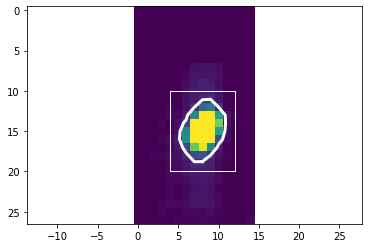

In [12]:
fig, ax = plt.subplots()
img = loadImg(df.iloc[1234].Matrix)
x,y = findCon(img)

ax.set_aspect('equal', 'datalim')
plt.imshow(img)

ax.plot(x,y, color='#ffffff', linewidth=3, alpha=1.0)
x1,y1,x2,y2 = int(x.min()-1), int(y.min()-1), int(x.max()+2), int(y.max()+2)
ax.add_patch(patches.Rectangle( (x1, y1), x2- x1, y2-y1, fill=False, color='#ffffff'))
plt.show()

### fit all blobs in a 22 x 15 empy image upper left corner

In [13]:
%%time

def doJob(df2):
    lst = []
    for i, d in df2.iterrows():
        wall = np.zeros((22, 15),dtype=np.float64)
        wall[0:d.TouchH, 0:d.TouchW] = d.Matrix[d.TouchY:(d.TouchY+d.TouchH), d.TouchX:(d.TouchX+d.TouchW)]
        lst.append(wall)
    return lst

p = Pool(cpu_count)

data =  np.array_split(df, cpu_count)
pool_results = p.map(doJob, data)
p.close()
del data
results = []
for result in pool_results:
    results.extend(result)
    
df["MatrixCroppedSameSize"] = results

CPU times: user 7.59 s, sys: 3.36 s, total: 10.9 s
Wall time: 10.2 s


In [14]:
df.head()

,Pair,Participant,Condition,Matrix,Pitch,Yaw,TimeOffset,IsFlipped,TouchX,TouchY,TouchH,TouchW,MatrixCropped,MatrixCroppedSameSize
214,107,1,2,"[[220, 0, 0, -3, -2, -3, -1, -1, -1, 0, 0, -27...",14.614879,-88.972128,-0.000106,True,0,9,9,7,"[[11.0, 13.0, 13.0, 13.0, 13.0, 7.0, 0.0], [16...","[[11.0, 13.0, 13.0, 13.0, 13.0, 7.0, 1.0, 0.0,..."
215,107,1,2,"[[0, 0, -2, -27, 0, 0, -1, -1, -1, -3, -2, -3,...",14.614879,88.972128,-0.000106,False,7,9,9,8,"[[0.0, 0.0, 7.0, 13.0, 13.0, 13.0, 13.0, 11.0]...","[[1.0, 1.0, 7.0, 13.0, 13.0, 13.0, 13.0, 11.0,..."
216,108,1,2,"[[220, 0, 0, -3, -2, -3, -1, -1, -1, 0, 0, -27...",28.088492,-78.902481,-0.000926,True,0,9,9,7,"[[8.0, 10.0, 9.0, 10.0, 8.0, 4.0, 0.0], [15.0,...","[[8.0, 10.0, 9.0, 10.0, 8.0, 4.0, 1.0, 0.0, 0...."
217,108,1,2,"[[0, 0, -2, -27, 0, 0, -1, -1, -1, -3, -2, -3,...",28.088492,78.902481,-0.000926,False,7,9,9,8,"[[0.0, 0.0, 4.0, 8.0, 10.0, 9.0, 10.0, 8.0], [...","[[2.0, 1.0, 4.0, 8.0, 10.0, 9.0, 10.0, 8.0, 0...."
218,109,1,2,"[[0, 0, -2, -27, 0, 0, -1, -1, -1, -3, -2, -3,...",28.257708,79.029943,-0.001010,False,7,10,8,8,"[[0.0, 0.0, 6.0, 8.0, 12.0, 12.0, 11.0, 11.0],...","[[2.0, 3.0, 6.0, 8.0, 12.0, 12.0, 11.0, 11.0, ..."


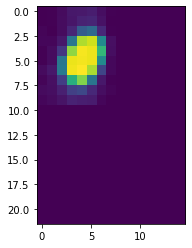

In [15]:
plt.imshow(df.iloc[1234].MatrixCroppedSameSize)
plt.show()

In [16]:
df.to_pickle("./data/all_data.pkl")